# Supp. Fig. S2E
The goal of this experiment is to ask if rotational OMR, which we established in Fig. S2A-C, has memory-dependence as in the forward OMR (in Fig. 1).

Fish experienced 3-s long open-loop rotational motion, followed by 20-s closed-loop rotation, with or without 5-s wait periods in between.

Please see **Table S1** for the detail of the stimulus structure.

In [4]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
import colorcet as cc
from scipy.stats import binned_statistic
from scipy.signal import convolve
from homr_util import *
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = "./data/figS2_02"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 29 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Downsample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type
- Smooth turn data, because they look too "spiky"
- We are only interested in the relative directionality of priming and probe rotations. Such that, we will 'fold' data so that the probe direction is positive

In [6]:
bin_dt = 1/20 # downsample to 20Hz
all_traces = [] # Store image angle (this is not shown)
all_vtraces = [] # Store smoothed turning velocity

# bins
time_bin = np.arange(0,38,bin_dt)
binned_t = (time_bin[1:]+time_bin[:-1])/2

# Go through all fish
for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # Timestamps (stimulus presentation coordinate, 60 Hz-ish)
    t_s = exp.stimulus_log['t'].to_numpy()
    # The stimulus angle
    theta = exp.stimulus_log['seamless_image_theta'].to_numpy() / np.pi * 180
    # Turn spikes at bout onsets
    fish_vel = exp.stimulus_log['seamless_image_fish_theta'].to_numpy() * exp.stimulus_log['seamless_image_start_theta_update'].to_numpy() / np.pi * 180 
    
    # lists of lists to store snippets
    traces = [[] for i in range(6)]
    v_traces = [[] for i in range(6)]
    
    # go through epochs
    for epoch in slog:
        
        # first, figure out which type of epoch this was
        dw = epoch['duration_wait'] # either 0 or 5
        vo = np.round(epoch['vel_drift_ol']/np.pi*180) # -30, 0, 30
        vc = np.round(epoch['vel_drift_cl']/np.pi*180) # -30 or 30
        
        # assign epoch index (with 'folding')
        # {no-wait, wait} x {pre-contra, pre-0, pre-ipsi}
        epoch_id = int(3*(dw>0) + (1+np.sign(vo)*np.sign(vc)))
        
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        
        # cut out snippets (trust end more than start) & do baseline subtraction
        this_epoch_ind = np.logical_and(t_s>(t_end-duration), t_s<=t_end)
        this_t = t_s[this_epoch_ind]
        this_th = theta[this_epoch_ind]
        this_t = this_t - t_end + duration
        this_th = this_th - this_th[0]
        
        # do binning
        binned_th = binned_statistic(this_t, this_th, bins=time_bin)[0] * np.sign(vc)
        binned_fv = binned_statistic(this_t, fish_vel[this_epoch_ind], statistic='sum', bins=time_bin)[0] * np.sign(vc) / bin_dt
        
        # saving
        traces[epoch_id].append(binned_th)
        v_traces[epoch_id].append(binned_fv)
    
    all_traces.append(traces)
    all_vtraces.append(v_traces)

100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]


In [7]:
# Convert fish velocity traces into numpy array
all_vtraces = np.asarray(all_vtraces)

# Do smoothing
smoothing_window = 20 # number of samples. We downsampled data to 20 Hz, so 1 s
sm_vtraces = convolve(np.ones((1, 1, 1, smoothing_window))/smoothing_window, all_vtraces, method='direct')[:, :, :, :len(binned_t)]

# Average over trials
vtrial_mean = np.nanmean(sm_vtraces, axis=2)

# Calculate differences by priming directions (with normalization)
vdiff_trace = np.mean(vtrial_mean[:,(2,5),:] - vtrial_mean[:,(0,3),:], axis=0)
pooled_std = np.sqrt(0.5*(np.nanvar(vtrial_mean[:,(2,5),:], axis=0)+np.nanvar(vtrial_mean[:,(2,5),:], axis=0)))
cohens_d = vdiff_trace / pooled_std

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_7124\2221065172.py:14: RuntimeWarning: divide by zero encountered in true_divide
  cohens_d = vdiff_trace / pooled_std
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_7124\2221065172.py:14: RuntimeWarning: invalid value encountered in true_divide
  cohens_d = vdiff_trace / pooled_std


## Panels
### Fig. S2E (Probe angular velocity by priming and wait conditions)

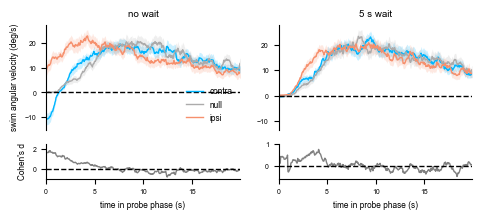

In [8]:
label = ('contra', 'null', 'ipsi')

# Plot turning bias
fig, ax= plt.subplots(2,2, figsize=(5.5,2), height_ratios=(3,1))
for i in range(3):
    plot_mean_sem(ax[0, 0], binned_t-13, vtrial_mean[:, i, :], color=cc.cm.CET_D11(i/2), label=label[i])
    
for i in range(3):
    plot_mean_sem(ax[0, 1], binned_t-18, vtrial_mean[:, i+3, :], color=cc.cm.CET_D11(i/2), label=label[i])

ax[0, 0].set_title('no wait')
ax[0, 1].set_title('5 s wait')

# plot by-direction effect size
ax[1, 0].plot(binned_t-13, cohens_d[0,:], color=(0.5,0.5,0.5))
ax[1, 1].plot(binned_t-18, cohens_d[1,:], color=(0.5,0.5,0.5))

# adjust axes
for axx in ax:
    for axxx in axx:
        axxx.set_xlim([0, 19.95])

for axx in ax[0]:
    axx.plot([0,20], [0,0], 'k--')
    toggle_spines(axx, 0, 0, 0, 1)

ax[0,0].legend(frameon=False)
ax[0,0].set_ylabel('swim angular velocity (deg/s)')   
ax[1,0].set_ylabel('Cohen\'s d')

for axx in ax[1]:
    axx.plot([0,20], [0,0], 'k--')
    axx.set_xlabel('time in probe phase (s)')
    axx.set_xticks(np.arange(0,20,5))
    toggle_spines(axx, 0, 1, 0, 1)
ax[1, 0].set_ylim((-1, 2.5))
ax[1, 1].set_ylim((-0.6, 1))

plt.savefig('./svgs/FigS2E.svg', format='svg')
plt.show()